In [11]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import zipfile
 

%matplotlib inline

In [12]:
import os
os.chdir('/Users/Niloufar/Documents/Microsoft_Movie_Analysis')

In [13]:
#Load IMDB dataset
zf = zipfile.ZipFile('zippedData/im.db.zip', 'r')
conn = sqlite3.connect('im.db')
q = """
SELECT * FROM movie_basics
JOIN movie_ratings
    USING (movie_id);
"""
imdb = pd.read_sql(q, conn)

In [14]:
#Load BOM dataset
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')

In [15]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [16]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [17]:
"""
This module is for your data cleaning.
It should be repeatable.
If you are combining different data sources you might need a few different functions

## Data links:


## SUPPORT FUNCTIONS
There can be an unlimited amount of support functions.
Each support function should have an informative name and return the partially cleaned bit of the dataset.
"""
import pandas as pd
import os 

def prep_imdb(imdb):
    """This finction reads in the data from imdb and clean it"""
    imdb.columns = imdb.columns.str.lower().str.replace(' ', '_')
    imdb.drop(columns = ['movie_id','original_title'], inplace=True)
    imdb.rename({'primary_title':'title'}, axis=1, inplace=True)
    imdb['title'] = imdb['title'].str.title()
    imdb.rename({'start_year':'year'},axis=1, inplace=True)
    imdb.rename({'runtime_minutes':'runtime[min]'},axis=1, inplace=True)
    return imdb

def prep_bom(bom):
    """This function might read in and clean a different data source"""
    bom.columns = bom.columns.str.lower().str.replace(' ', '_')
    bom.drop(columns = ['studio'], inplace = True)
    bom['title'] = bom['title'].str.title()
    return bom

def merge_imdb_bom(imdb_df, bom_df):
    """This one might merge the above two sources and create a few new variables"""
    df = pd.merge(imdb_df, bom_df, on=['title', 'year'])
    df.dropna(subset= ['domestic_gross','foreign_gross','genres','runtime[min]'], inplace=True)
    df['total_gross'] = df['domestic_gross'].astype(float) + df['foreign_gross'].str.replace(',', '').astype(float)
    df.sort_values(by=['total_gross'], inplace=True, ascending=False)
    df.reset_index(drop=True, inplace=True)
    df = df.join(df['genres'].str.split(",",expand=True).add_prefix('genre'))
    return df

def full_clean(imdb, bom):
    """
    This is the one function called that will run all the support functions.
    Assumption: 
        - Your data files will be saved in a data folder and named "dirty_data.csv"
        - OR you might read directly from a few urls
        - this code is guidance, not rules

    :return: cleaned dataset to be passed to hypothesis testing and visualization modules.
    """
    imdb_clean = prep_imdb(imdb)
    bom_clean = prep_bom(bom)
    cleaned_data= merge_imdb_bom(imdb_clean, bom_clean)
#leaned_data.to_csv('./data/cleaned_dataset.csv')
    
    return cleaned_data

In [18]:
clean_df = full_clean(imdb,bom)

In [19]:
clean_df

,title,year,runtime[min],genres,averagerating,numvotes,domestic_gross,foreign_gross,total_gross,genre0,genre1,genre2
0,Avengers: Age Of Ultron,2015,141.0,"Action,Adventure,Sci-Fi",7.3,665594,459000000.0,946400000,1.405400e+09,Action,Adventure,Sci-Fi
1,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",7.3,516148,700100000.0,646900000,1.347000e+09,Action,Adventure,Sci-Fi
2,Star Wars: The Last Jedi,2017,152.0,"Action,Adventure,Fantasy",7.1,462903,620200000.0,712400000,1.332600e+09,Action,Adventure,Fantasy
3,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi",6.2,219125,417700000.0,891800000,1.309500e+09,Action,Adventure,Sci-Fi
4,Frozen,2013,102.0,"Adventure,Animation,Comedy",7.5,516998,400700000.0,875700000,1.276400e+09,Adventure,Animation,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...
1296,Freakonomics,2010,93.0,Documentary,6.4,6466,101000.0,16400,1.174000e+05,Documentary,None,None
1297,Band Baaja Baaraat,2010,139.0,"Comedy,Drama,Romance",7.2,13832,43800.0,60700,1.045000e+05,Comedy,Drama,Romance
1298,As Good As Dead,2010,100.0,"Crime,Thriller",5.2,1441,2000.0,53600,5.560000e+04,Crime,Thriller,None
1299,Inhale,2010,83.0,"Drama,Thriller",6.6,6006,4100.0,51000,5.510000e+04,Drama,Thriller,None


In [20]:
genre_vs_gross = clean_df[['domestic_gross','foreign_gross','genre0']]
genre_vs_gross['foreign_gross'].replace(',','', regex=True, inplace=True)
genre_vs_gross['foreign_gross'] = genre_vs_gross['foreign_gross'].astype('float64')


/Users/Niloufar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-20-0c9bcd35117a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_vs_gross['foreign_gross'] = genre_vs_gross['foreign_gross'].astype('float64')


In [21]:
import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.ticker as ticker
import seaborn as sns

# Standard data manipulation packages
import pandas as pd
import numpy as np

In [22]:
pal = sns.color_palette('BuPu_r')
pal.as_hex()


['#821580', '#894da3', '#8c7dba', '#96acd2', '#b5cce3', '#dce9f2']

In [23]:
pal.as_hex()[:]

['#821580', '#894da3', '#8c7dba', '#96acd2', '#b5cce3', '#dce9f2']

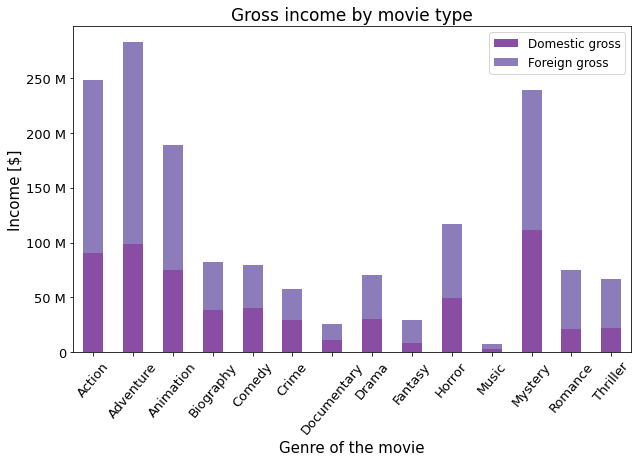

In [24]:
ax = genre_vs_gross.groupby('genre0').mean().plot(kind='bar', figsize=(10,6), fontsize=13, stacked=True, 
                                                     color = ['#894da3','#8c7dba'])
ax.set_xlabel('Genre of the movie', fontsize = 15)
ax.set_ylabel("Income [$]", fontsize=15);
ax.set_title("Gross income by movie type", fontsize=17)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000000.00))
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.xticks(rotation = 50)
plt.legend(labels=['Domestic gross', 'Foreign gross'], fontsize=12)
plt.savefig('./images/genre_vs_income.png', transparent = True)    
plt.show()

In [25]:
# genre_vs_rating = clean_df[['averagerating','genre0']]

# ax = genre_vs_rating.groupby('genre0').median().plot(kind='bar', figsize=(10,6), fontsize=13, stacked=True, 
#                                                     color = ['royalblue'])
# ax.set_xlabel('Genre of the movie', fontsize = 15)
# ax.set_ylabel("Average rating", fontsize=15);
# ax.set_title("Average rating by movie type", fontsize=22)
# plt.xticks(rotation = 50)
# plt.legend(fontsize=12)
# plt.savefig('./images/genre_vs_income.png', transparent = True)    
# plt.show()

In [26]:
genre_vs_rating = clean_df[['averagerating','genre0','numvotes']]
df = genre_vs_rating.groupby('genre0').agg('median')
df = df.reset_index()

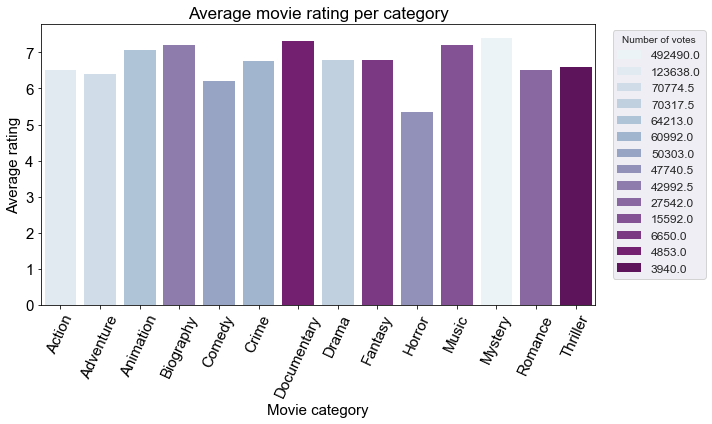

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
labels = list(df['genre0'].unique())
sns.barplot(
    x="genre0",
    y="averagerating",
    data=df,
    hue="numvotes",
    ax=ax,
    palette="BuPu_r",
    dodge=False,
)
sns.set_style(
    "darkgrid")
ax.set_title("Average movie rating per category", fontsize=17)
ax.set_xlabel("Movie category", fontsize=15)
ax.set_ylabel("Average rating", fontsize=15)
ax.set_xticklabels(labels= labels, size=15, rotation=65)
ax.tick_params(axis='y', labelsize=15)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title="Number of votes",bbox_to_anchor=(1.02, 1.0), loc='upper left', fontsize=12, fancybox=True)
plt.tight_layout()
plt.savefig('./images/genre_vs_rating.png', transparent = True)    

plt.show()

In [28]:
genre_vs_rating = clean_df[['genre0', 'averagerating', 'numvotes']]
df = genre_vs_rating[['genre0', 'averagerating']].groupby('genre0').agg('median')
df = df.reset_index()
df.rename(columns={'averagerating':'rating'}, inplace=True)
genre_vs_rating = pd.merge(genre_vs_rating,df, on='genre0')

In [29]:
fig, ax = plt.subplots(figsize=(25,6), ncols=1)
labels = list(genre_vs_rating['genre0'].unique())
sns.boxplot(x="genre0",
                y="averagerating",
                data=genre_vs_rating,
                ax=ax,
                #palette="BuPu_r",
                color = '#8c7dba',
                #dodge=False,
                order = 
)
sns.stripplot(x="genre0",
              y="averagerating",
              data=genre_vs_rating,
              #palette="BuPu_r",
              color = '#821580'
)
sns.set_style(
    "darkgrid")
ax.set_title("Average movie rating per category", fontsize=32)
ax.set_xlabel("Movie category", fontsize=30)
ax.set_ylabel("Average rating", fontsize=30)
ax.set_xticklabels(labels= labels, size=25, rotation=65)
ax.tick_params(axis='y', labelsize=30)
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles[::-1], labels[::-1], title="Number of votes",bbox_to_anchor=(1.02, 1.0), loc='upper left', fontsize=12, fancybox=True)
ax.legend().remove()
#plt.tight_layout()



SyntaxError: invalid syntax (<ipython-input-29-2026de96f7d4>, line 11)

In [30]:
genre_vs_numvotes = clean_df[['genre0','numvotes']]
df = genre_vs_numvotes.groupby('genre0').agg('mean')
df = df.reset_index()
df

,genre0,numvotes
0,Action,184325.309002
1,Adventure,133073.583333
2,Animation,95784.000000
3,Biography,116446.250000
4,Comedy,79045.179775
5,Crime,117724.814815
6,Documentary,9164.531250
7,Drama,106290.937500
8,Fantasy,26341.833333
9,Horror,78642.537037


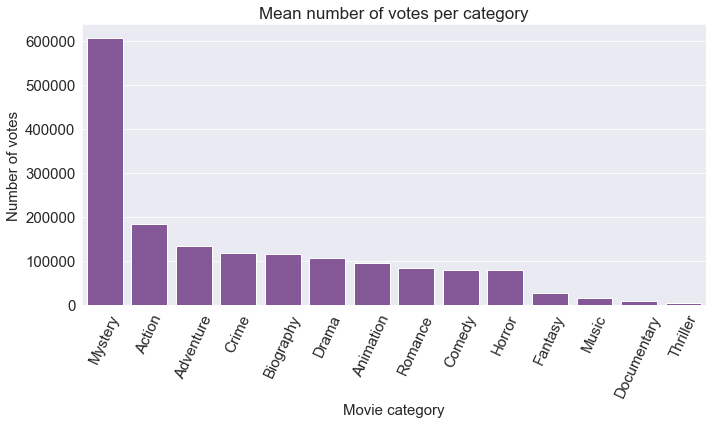

In [31]:
mean_by_genre = genre_vs_numvotes.groupby('genre0')['numvotes'].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,6))
labels = mean_by_genre.index
sns.barplot(
    x="genre0",
    y="numvotes",
    data=df,
    ax=ax,
    #palette='BuPu_r',
    #hue = df["numvotes"].values.astype(int),
    #hue_order = np.sort(df["numvotes"].values.astype(int))[::-1],
    dodge=False,
    color = '#894da3',
    order = mean_by_genre.index
)
sns.set_style(
    "darkgrid")
ax.set_title("Mean number of votes per category", fontsize=17)
ax.set_xlabel("Movie category", fontsize=15)
ax.set_ylabel("Number of votes", fontsize=15)
ax.set_xticklabels(labels= labels, size=15, rotation=65)
ax.tick_params(axis='y', labelsize=15)
handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels, title="Average number of votes",bbox_to_anchor=(1.02, 1.0), loc='upper left', fontsize=12, fancybox=True)
plt.tight_layout()
plt.savefig('./images/genre_vs_numvotes.png', transparent = True)    

plt.show()

In [32]:
runtime_vs_gross = clean_df[['total_gross','runtime[min]']]
runtime_vs_rating = clean_df[['averagerating','runtime[min]']]

<ipython-input-35-329097493365>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_vs_gross["Runtime"] = time_intervals
<ipython-input-35-329097493365>:28: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax1.set_yscale('log', nonposy='clip')
<ipython-input-35-329097493365>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_vs_rating["Runtime"] = time_inte

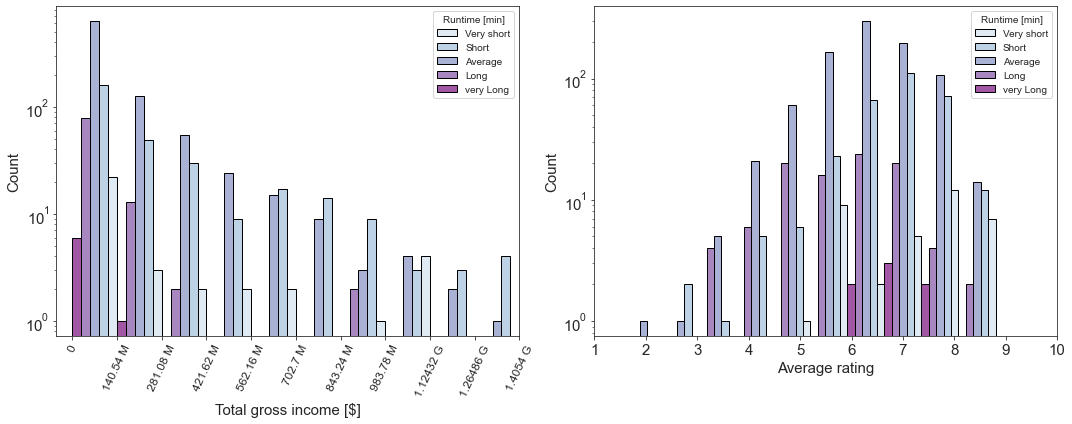

In [35]:
time_intervals = pd.cut(runtime_vs_gross["runtime[min]"], bins=5)
runtime_vs_gross["Runtime"] = time_intervals

fig, [ax1,ax2] = plt.subplots(1,2,figsize=(15,6))
sns.histplot(
    data = runtime_vs_gross,
    x="total_gross",
    hue="Runtime",
    palette="BuPu_r",
    bins=10,
    kde=False,
    ax=ax1,
    multiple="dodge",
    linewidth=1,
    edgecolor='black'
)
sns.set_style("ticks")
#ax1.set_title("Total gross income vs movie runtime", fontsize=17)
ax1.set_xlabel("Total gross income [$]", fontsize=15)
ax1.set_ylabel("Count", fontsize=15)
ax1.set_xlim([-0.5e8, np.max(runtime_vs_gross["total_gross"])])
ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(np.max(runtime_vs_gross["total_gross"])/10))
ax1.xaxis.set_major_formatter(ticker.EngFormatter())
ax1.legend(title="Runtime [min]", labels=['Very short', 'Short', 'Average', 'Long', 'very Long'])
ax1.tick_params(axis='x', labelsize=12, rotation=65)
ax1.tick_params(axis='y', labelsize=15)
ax1.set_yscale('log', nonposy='clip')

time_intervals = pd.cut(runtime_vs_rating["runtime[min]"], bins=5)
runtime_vs_rating["Runtime"] = time_intervals

sns.histplot(
    data = runtime_vs_rating,
    x="averagerating",
    hue="Runtime",
    palette="BuPu_r",
    bins=10,
    kde=False,
    ax=ax2,
    multiple='dodge',
    linewidth=1,
    edgecolor='black',
)
sns.set_style("white")
#ax1.set_title("Total gross income vs movie runtime", fontsize=17)
ax2.set_xlabel("Average rating", fontsize=15)
ax2.set_ylabel("Count", fontsize=15)
ax2.tick_params(axis='x', labelsize=15)
ax2.tick_params(axis='y', labelsize=15)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10])
ax2.legend(title="Runtime [min]", labels=['Very short', 'Short', 'Average', 'Long', 'very Long'])
ax2.set_yscale('log', nonposy='clip')

plt.tight_layout()
plt.savefig('./images/runtime_vs_income.png', transparent = True)    
plt.show()

In [ ]:
ax.set_xlabel('Genre of the movie', fontsize = 15)
ax.set_ylabel("Income [$]", fontsize=15);
ax.set_title("Gross income by movie type", fontsize=17)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_locator(ticker.MultipleLocator(50000000.00))
ax.yaxis.set_major_formatter(ticker.EngFormatter())
plt.xticks(rotation = 50)
plt.legend(labels=['Domestic gross', 'Foreign gross'], fontsize=12)
plt.savefig('./images/genre_vs_income.png', transparent = True)    
plt.show()

/Users/Niloufar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-34-ed00d35ff0c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_vs_year['foreign_gross'] = income_vs_year['foreign_gross'].astype('float64')


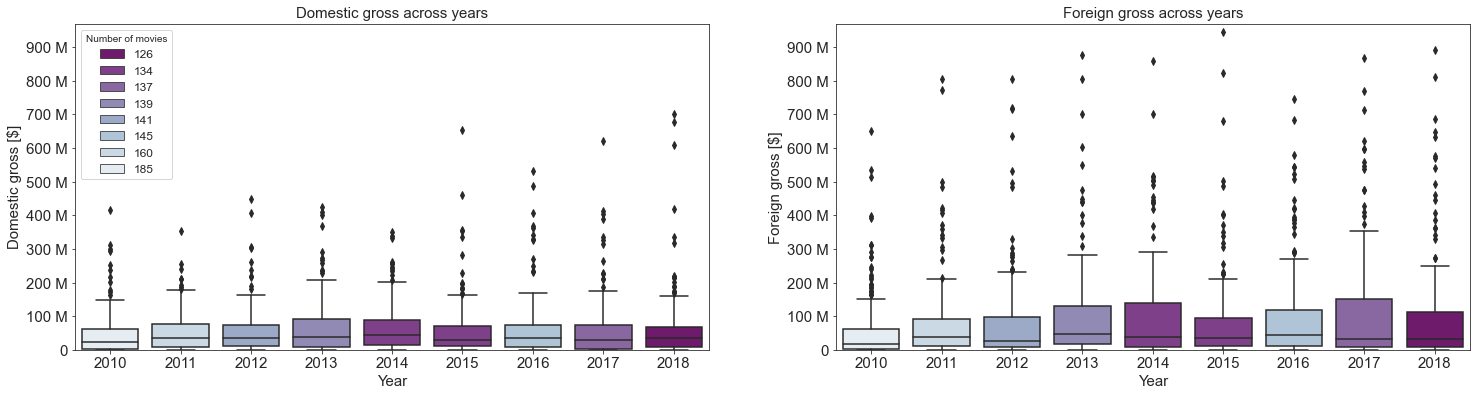

In [34]:
income_vs_year = clean_df[['year','domestic_gross','foreign_gross']]
income_vs_year['foreign_gross'].replace(',','', regex=True, inplace=True)
income_vs_year['foreign_gross'] = income_vs_year['foreign_gross'].astype('float64')
df = income_vs_year[['domestic_gross','year']].groupby('year').agg('count')
df.reset_index()
df.rename(columns={'domestic_gross':'count'}, inplace=True)
income_vs_year = pd.merge(income_vs_year, df, on='year')

fig, axes = plt.subplots(figsize=(25,6), ncols=2)
sns.boxplot(x="year",
                y="domestic_gross",
                data=income_vs_year,
                ax=axes[0],
                palette="BuPu_r",
                hue="count",
                dodge=False
)
sns.boxplot(x="year",
                y="foreign_gross",
                data=income_vs_year,
                ax=axes[1],
                palette="BuPu_r",
                hue="count",
                dodge=False    
)
axes[0].set_title('Domestic gross across years', fontsize=15)
axes[0].set_xlabel('Year', fontsize=15)
axes[0].set_ylabel('Domestic gross [$]', fontsize=15)
axes[0].set_ylim((-50000, 970000000))
axes[0].tick_params(axis='y', labelsize=15)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(100000000.00))
axes[0].yaxis.set_major_formatter(ticker.EngFormatter())
axes[0].legend(title="Number of movies",loc=2, fontsize=12, fancybox=True)
axes[1].set_title('Foreign gross across years', fontsize=15)
axes[1].set_xlabel('Year', fontsize=15)
axes[1].set_ylabel('Foreign gross [$]', fontsize=15)
axes[1].set_ylim((-50000, 970000000))
axes[1].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(100000000.00))
axes[1].yaxis.set_major_formatter(ticker.EngFormatter())
axes[1].legend().remove()


No handles with labels found to put in legend.


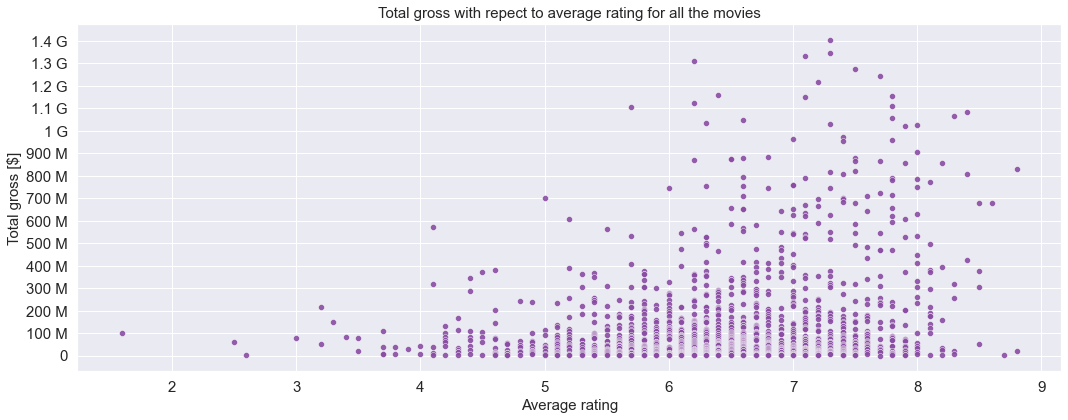

In [379]:
income_vs_vote = clean_df[['averagerating','total_gross','numvotes']]
fig, ax = plt.subplots(figsize=(15,6))
sns.scatterplot(
                x="averagerating",
                y="total_gross",
                data=income_vs_vote,
                alpha=0.9,
                color=['#894da3']
)
ax.set_title('Total gross with repect to average rating for all the movies', fontsize=15)
ax.set_xlabel('Average rating', fontsize=15)
ax.set_ylabel('Total gross [$]', fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100000000.00))
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.legend().remove()
ax.autoscale_view()
plt.tight_layout()#ax.legend(title="Number of votes",
#          loc=2, fontsize=15, fancybox=True)